## load the best policy net that is saved as checkpoint

In [17]:
import numpy as np
import torch

from environment import *
from DQN import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#order picking parameters
n_row = 17
n_aisle = 10
action_size = 5
capacity = 20
arrival_rate = 0.08

depot = 5
inter_aisle_distance = 3
pick_up_time = 5
drop_off_time = 1
alpha = 1

best_policy_net = QNetwork(action_size, n_aisle)

# best_policy_net.load_state_dict(torch.load('saved_models/old_model.pth'))
best_policy_net.load_state_dict(torch.load('saved_models/check_point_arrival_rate'+str(arrival_rate)+'_alpha'+str(alpha)+'.pth'))


<All keys matched successfully>

In [18]:
import pandas as pd



for rate in range(1,10):
    arrival_rate = 0.01 * rate

    total_dis = 0
    total_time = 0
    total_perc_unfullfilled = 0
    manuals = 0
    all_steps = 0

    for instance in range(1,11):
        df1 = pd.read_excel('instances/arrival_rate_'+str(arrival_rate)+'/arrival_rate_'+str(arrival_rate)+
                        '_instance_'+str(instance)+'.xlsx')

        import ast
        history = []
        for i in df1.arrivals:
            history.append(ast.literal_eval(i))


        minimum_pick_list = 1

        env = Env(n_row, n_aisle, arrival_rate, capacity, depot, inter_aisle_distance, pick_up_time, drop_off_time, alpha)
        stateM, stateP, allowed_actions, _, loc, prize = env.reset_test(history, minimum_pick_list)

        with torch.no_grad():
            while True:        
                action = best_policy_net.select_optimal_action(stateM, stateP, allowed_actions)
                stateM, stateP, reward, allowed_actions, _, loc, prize, final = env.step_test(action)
                if final:
                    break




        distances = 0
        times = 0
        count = 0
        num_delivered = len(env.delivered_orders)
        num_undelivered = env.order_count + len(env.orders_in_picker)
        for order in env.delivered_orders:
            count += 1
            distances += order.distance
            times += order.delivery_time - order.arrival_time

#         print(f'Ins. {instance}: Dis/order: {round(distances/count, 1)}, time/order: {round(times/count, 1)}\
#         , total = {num_delivered+num_undelivered} , unfullfilled = {num_undelivered}')

        total_dis += distances/count
        total_time += times/count
        total_perc_unfullfilled += num_undelivered*100/(num_delivered+num_undelivered)
        manuals += env.manual_steps
        all_steps += env.all_steps
    print()
    print(f'rate: {arrival_rate}, average Dis/order: {round(total_dis/10, 2)} , average time/order: {round(total_time/10, 1)}\
    , unfullfilled: {round(total_perc_unfullfilled/10, 2)}% , manual override: {round(manuals*100/all_steps, 2)}%')
    print()


rate: 0.01, average Dis/order: 70.31 , average time/order: 158.2    , unfullfilled: 0.66% , manual override: 6.35%


rate: 0.02, average Dis/order: 126.53 , average time/order: 252.5    , unfullfilled: 0.77% , manual override: 18.22%


rate: 0.03, average Dis/order: 141.88 , average time/order: 313.0    , unfullfilled: 1.08% , manual override: 32.89%


rate: 0.04, average Dis/order: 112.2 , average time/order: 304.4    , unfullfilled: 1.25% , manual override: 33.68%


rate: 0.05, average Dis/order: 87.12 , average time/order: 291.8    , unfullfilled: 0.96% , manual override: 29.19%


rate: 0.06, average Dis/order: 67.17 , average time/order: 295.0    , unfullfilled: 1.03% , manual override: 20.5%


rate: 0.07, average Dis/order: 54.66 , average time/order: 318.5    , unfullfilled: 0.97% , manual override: 14.37%


rate: 0.08, average Dis/order: 46.57 , average time/order: 369.0    , unfullfilled: 1.25% , manual override: 11.1%


rate: 0.09, average Dis/order: 40.0 , average time/order

# Create a random instance and Test the best saved policy net visually

<IPython.core.display.Javascript object>


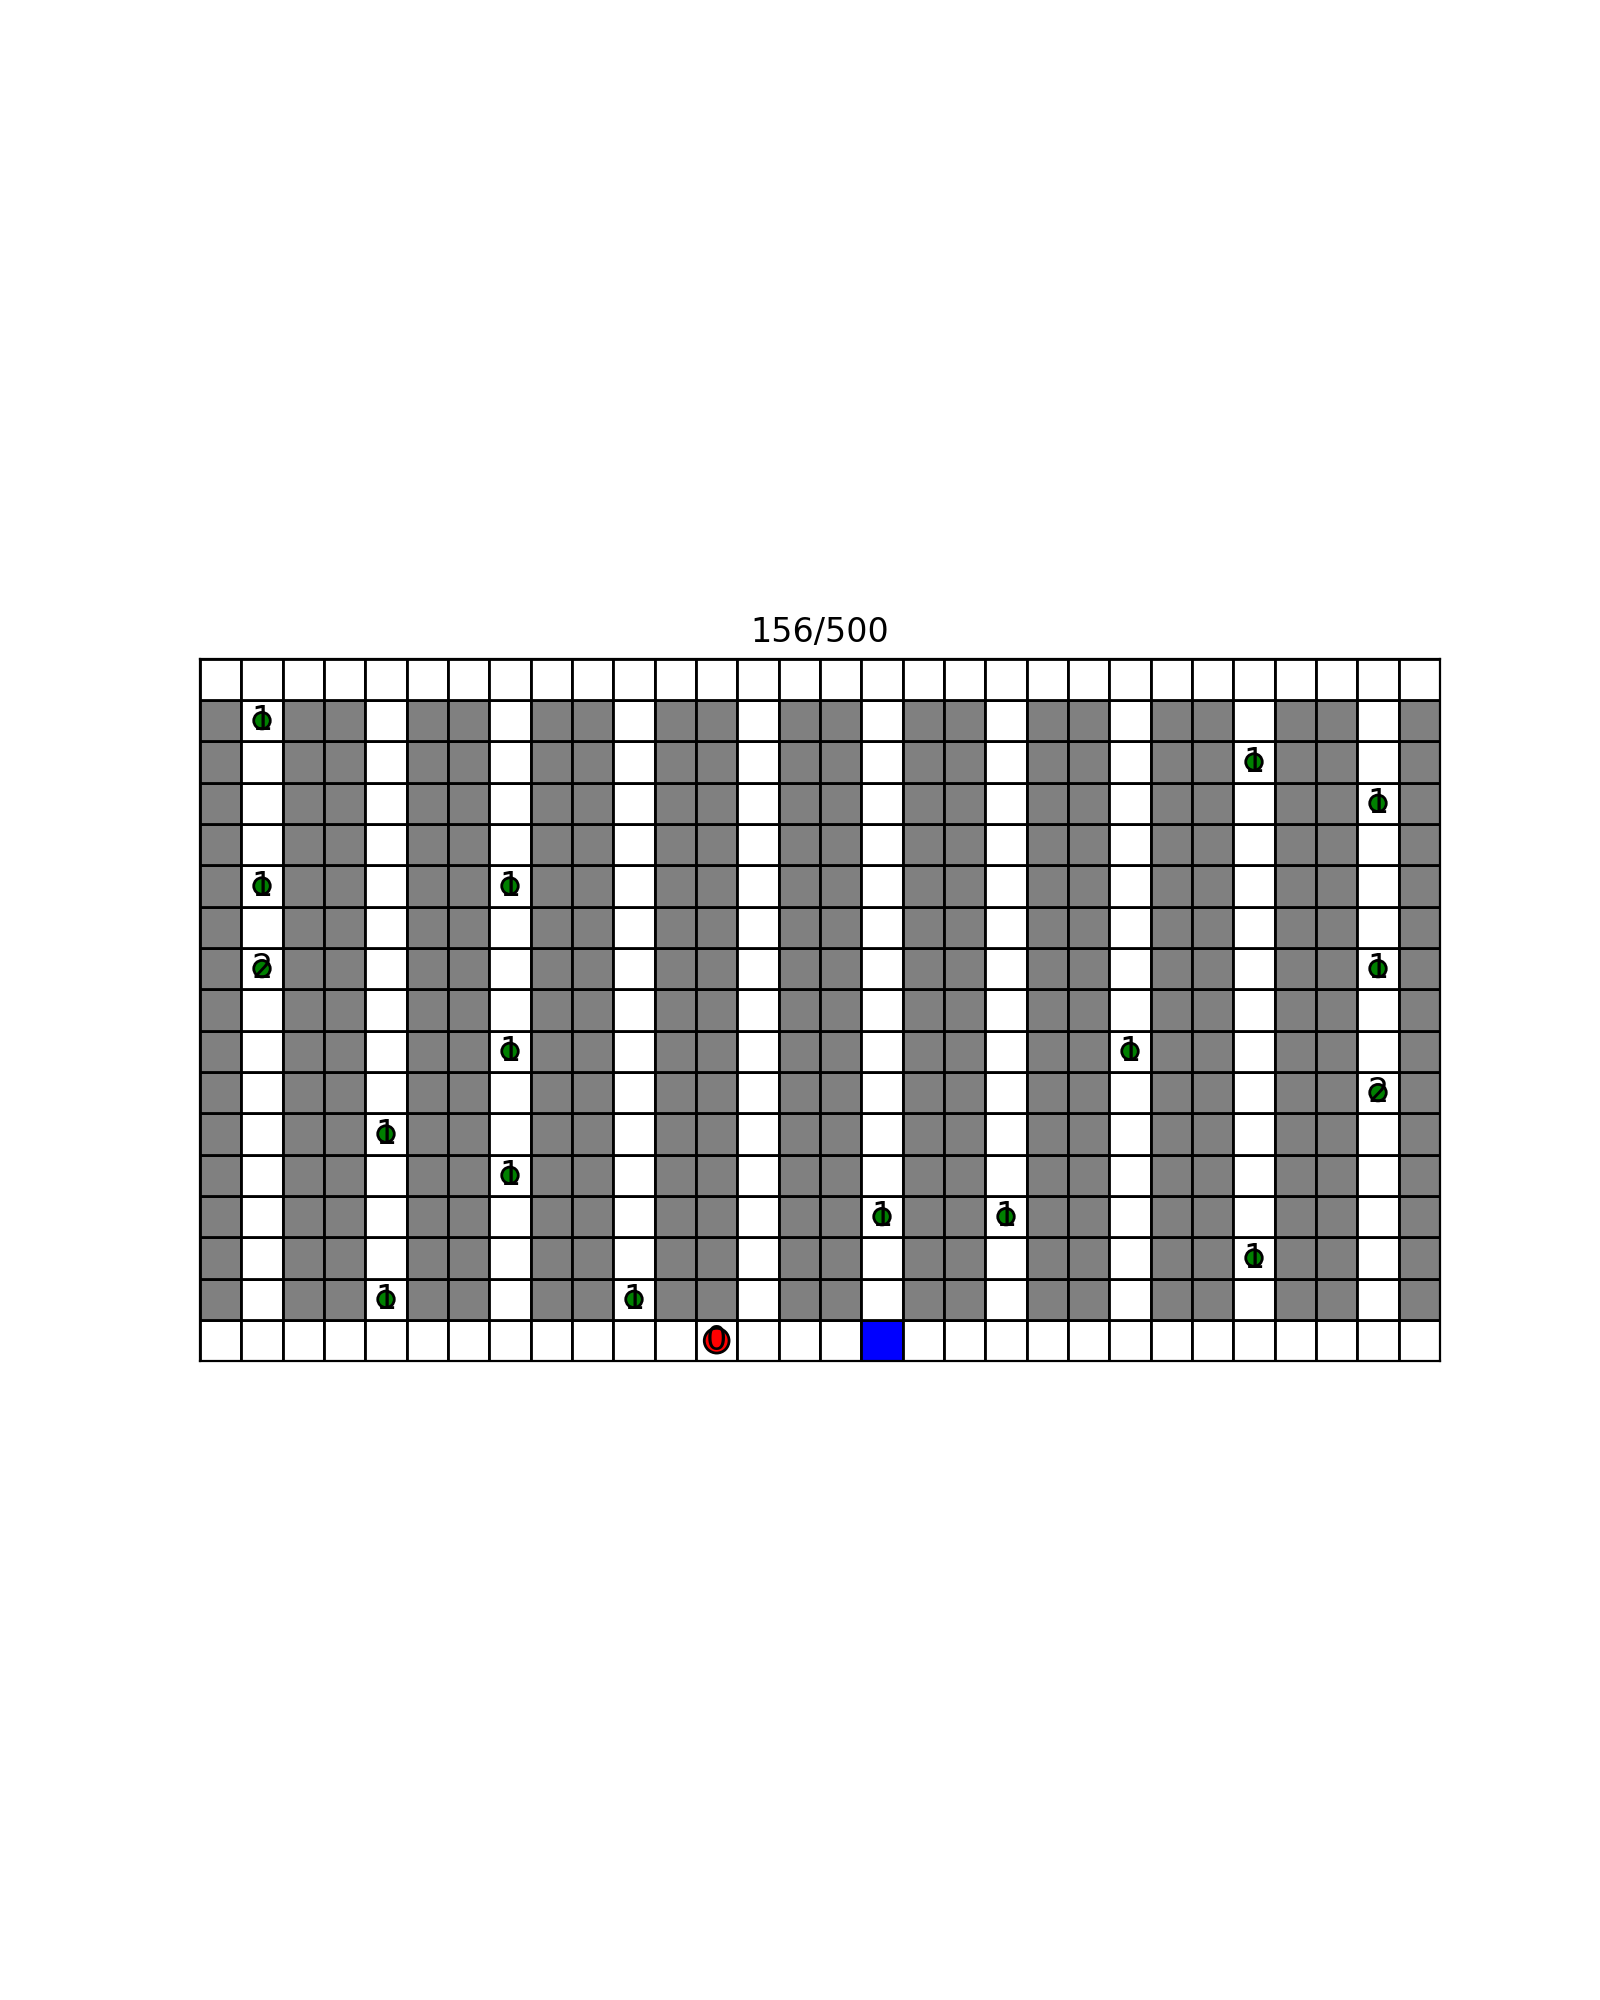

In [2]:
import pandas as pd

arrival_rate = 0.09
instance = 1
df1 = pd.read_excel('instances/arrival_rate_'+str(arrival_rate)+'/arrival_rate_'+str(arrival_rate)+
                        '_instance_'+str(instance)+'.xlsx')

import ast
history = []
for i in df1.arrivals:
    history.append(ast.literal_eval(i))
            
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

%matplotlib notebook


def draw_grid(n_row, n_aisle, depot_col):
    n_col = n_aisle * 3 
    fig, ax = plt.subplots(figsize=(8, 10))

    for i in range(n_row):
        for j in range(n_col):
            blue_condition = i == 0 and j == depot_col
            black_condition = j%3!=1 and 0<i and i<n_row-1
            color = 'gray' if black_condition else 'white'
            if blue_condition:
                color = 'blue'
            square = plt.Rectangle((j,i), 1, 1, fc=color, ec='black')
            ax.add_patch(square)

    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(0, n_col)
    ax.set_ylim(0, n_row)

    return fig, ax

# Function to create a circle

def create_circle(stateM, stateP, circles, texts):
    row, col, room = stateM
    row_ = n_row - 1 - row
    color = 'red'
    circle1 = plt.Circle((col + 0.5, row_ + 0.5), 0.3, fc=color, ec='black')
    ax.add_patch(circle1)
    text_object = ax.text(col + 0.5, row_ + 0.5, str(room.item()), color='black', ha='center', va='center', fontsize=12)
    circles.append(circle1)
    texts.append(text_object)

    for i in range(stateP.shape[0]):
        for j in range(stateP.shape[1]):
            if stateP[i,j] > 0:
                row_ = n_row - 1 - i
                color = 'green'
                circle2 = plt.Circle((j + 0.5, row_ + 0.5), 0.2, fc=color, ec='black')
                ax.add_patch(circle2)
                circles.append(circle2)
                text_object = ax.text(j + 0.5, row_ + 0.5, str(int(stateP[i,j].item())), color='black', ha='center', va='center', fontsize=12)
                texts.append(text_object)
                

minimum_pick_list = 1

saved_trajectory = []
actions = []
rewards = []

# shift_length = 8 * 3600
# shift_length = 10000
env = Env(n_row, n_aisle, arrival_rate, capacity, depot, inter_aisle_distance, pick_up_time, drop_off_time, alpha)
stateM, stateP, allowed_actions, _, loc, prize = env.reset_test(history, minimum_pick_list)
statesM = [loc]
prizes = [prize]
info = []
info_added = 0

with torch.no_grad():
    while True:
        action = best_policy_net.select_optimal_action(stateM, stateP, allowed_actions)
        stateM, stateP, reward, allowed_actions, _, loc, prize, final = env.step_test(action)
        saved_trajectory.append((stateM, stateP, action, loc, prize))
        for i in range(len(loc)):
            statesM.append(loc[i])
            prizes.append(prize[i])
        if len(statesM) >= 15000:
            if info_added < 5:
                info.append((stateM, stateP, action))
                info_added += 1
                
        if final:
            break

        
fig, ax = draw_grid(n_row, n_aisle, env.depot_col)
circles = []  # List to store the circle objects
texts = []

statesM = statesM[500:1000]
prizes = prizes[500:1000]

def update(frame):
    plt.title(f'{frame}/{len(statesM)}')
    for circle in circles:
        circle.remove()  # Remove the previous circles
    for text_object in texts:
        text_object.remove()
    circles.clear()
    texts.clear()
    stateM = statesM[frame]
    stateP = prizes[frame]
    create_circle(stateM, stateP, circles, texts)
    
anim = FuncAnimation(fig, update, frames=len(statesM), repeat=False, interval=20)

# Display the animation
plt.show()
# anim.save("10_row_5_shelves_arrival_rate=0.1_capacity=15.gif", writer= "pillow")

# Save the randomly genearted instance
### set instance number

In [30]:

import pandas as pd

minimum_pick_list = 1
shift_length = 8 * 3600

for rate in range(1,2):
    arrival_rate = rate * 0.01
    print("arrival rate: ", arrival_rate)
    for instance in range(1,11):

        history = []

        env = Env(n_row, n_aisle, arrival_rate, capacity, depot, inter_aisle_distance, pick_up_time, drop_off_time, alpha)
        stateM, stateP, allowed_actions, _, loc, prize = env.reset_test(history, minimum_pick_list)
        with torch.no_grad():
            while True:   
                if env.time_step >= shift_length:
                    break
                action = best_policy_net.select_optimal_action(stateM, stateP, allowed_actions)
                stateM, stateP, reward, allowed_actions, _, loc, prize, final = env.step_test(action)





        distances = 0
        times = 0
        count = 0
        for order in env.delivered_orders:
            count += 1
            distances += order.distance
            times += order.delivery_time - order.arrival_time
        #     print(f'distance: {order.distance} , time: {order.delivery_time - order.arrival_time}')

        print(f'Distance per order: {round(distances/count, 1)}, time per order: {round(times/count, 1)}')
        history = env.history[:shift_length].copy()


        # Sample DataFrame
        data = {'time step': [i for i in range(len(history))],
                'arrivals': history}
        df = pd.DataFrame(data)

        # Write DataFrame to Excel file
        if not os.path.exists('instances/arrival_rate_'+str(arrival_rate)):
            os.makedirs('instances/arrival_rate_'+str(arrival_rate))

        df.to_excel('instances/arrival_rate_'+str(arrival_rate)+'/arrival_rate_'+str(arrival_rate)+
                    '_instance_'+str(instance)+'.xlsx', index=False)

arrival rate:  0.01
Distance per order: 1990.5, time per order: 2722.2
Distance per order: 1983.9, time per order: 3923.2
Distance per order: 30.1, time per order: 153.2
Distance per order: 3459.4, time per order: 5074.0
Distance per order: 3845.7, time per order: 4391.0
Distance per order: 5583.4, time per order: 8237.9
Distance per order: 3281.0, time per order: 3808.3


KeyboardInterrupt: 

In [21]:
print(len(history))

28800


# Load one of the saved instances and run it on the best policy

In [4]:
import pandas as pd
instance = 1

df1 = pd.read_excel('instances/nrow'+str(n_row)+'_naisle'+str(n_aisle)+'_arrival_rate_'+str(arrival_rate)+
                    '_instance_'+str(instance)+'.xlsx')

import ast
history = []
for i in df1.arrivals:
    history.append(ast.literal_eval(i))
    

    
minimum_pick_list = 5

env = Env(n_row, n_aisle, arrival_rate, capacity, depot, inter_aisle_distance, pick_up_time, drop_off_time)
stateM, stateP, allowed_actions, _, loc, prize = env.reset_test(history, minimum_pick_list)

with torch.no_grad():
    while True:        
        action = best_policy_net.select_optimal_action(stateM, stateP, allowed_actions)
        stateM, stateP, reward, allowed_actions, _, loc, prize, final = env.step_test(action)
        if final:
            break
        
            
            
            
distances = 0
times = 0
count = 0
for order in env.delivered_orders:
    count += 1
    distances += order.distance
    times += order.delivery_time - order.arrival_time
#     print(f'distance: {order.distance} , time: {order.delivery_time - order.arrival_time}')

print(f'Distance per order: {round(distances/count, 1)}, time per order: {round(times/count, 1)}')

FileNotFoundError: [Errno 2] No such file or directory: 'instances/nrow17_naisle10_arrival_rate_0.01_instance_1.xlsx'

In [23]:
for order in env.delivered_orders:
    print(f'distance: {order.distance} , time: {order.delivery_time - order.arrival_time}')

distance: 11 , time: 110
distance: 35 , time: 206
distance: 48 , time: 84
distance: 55 , time: 98
distance: 56 , time: 142
distance: 56 , time: 106
distance: 85 , time: 170
distance: 97 , time: 153
distance: 12 , time: 165
distance: 27 , time: 118
distance: 28 , time: 61
distance: 37 , time: 104
distance: 40 , time: 145
distance: 53 , time: 336
distance: 53 , time: 129
distance: 58 , time: 168
distance: 62 , time: 319
distance: 62 , time: 231
distance: 74 , time: 257
distance: 95 , time: 221
distance: 98 , time: 271
distance: 9 , time: 467
distance: 12 , time: 328
distance: 35 , time: 57
distance: 45 , time: 76
distance: 55 , time: 163
distance: 56 , time: 304
distance: 56 , time: 166
distance: 62 , time: 265
distance: 70 , time: 305
distance: 70 , time: 168
distance: 18 , time: 25
distance: 18 , time: 267
distance: 18 , time: 75
distance: 22 , time: 108
distance: 23 , time: 256
distance: 24 , time: 429
distance: 27 , time: 588
distance: 29 , time: 154
distance: 45 , time: 155
distance

In [17]:
env.time_step

1214

In [17]:
count = 0
for (stateM, stateP, action, loc, prize) in saved_trajectory:
    print(stateM)
    count += 1
    if count >= 1000:
        break

tensor([ 1.,  8.,  9., 20.])
tensor([-1.,  8.,  9., 20.])
tensor([-1.,  6.,  7., 20.])
tensor([-1.,  4.,  5., 20.])
tensor([-1.,  2.,  3., 20.])
tensor([-1.,  0.,  1., 20.])
tensor([-1.,  0.,  1., 20.])
tensor([-1.,  0.,  1., 20.])
tensor([-1.,  0.,  1., 20.])
tensor([-1.,  0.,  1., 20.])
tensor([-1.,  0.,  1., 20.])
tensor([-1.,  0.,  1., 20.])
tensor([-1.,  0.,  1., 20.])
tensor([-1.,  0.,  1., 20.])
tensor([-1.,  0.,  1., 20.])
tensor([-1.,  0.,  1., 20.])
tensor([-1.,  0.,  1., 20.])
tensor([-1.,  0.,  1., 20.])
tensor([-1.,  0.,  1., 20.])
tensor([-1.,  0.,  1., 20.])
tensor([-1.,  0.,  1., 20.])
tensor([-1.,  0.,  1., 20.])
tensor([-1.,  0.,  1., 20.])
tensor([-1.,  0.,  1., 20.])
tensor([-1.,  0.,  1., 20.])
tensor([-1.,  0.,  1., 20.])
tensor([-1.,  0.,  1., 20.])
tensor([-1.,  0.,  1., 20.])
tensor([-1.,  0.,  1., 20.])
tensor([-1.,  0.,  1., 20.])
tensor([-1.,  0.,  1., 20.])
tensor([-1.,  0.,  1., 20.])
tensor([-1.,  0.,  1., 20.])
tensor([-1.,  0.,  1., 20.])
tensor([-1.,  

tensor([ 1., 10., 11.,  8.])
tensor([ 1., 10., 11., 20.])
tensor([ 1., 12., 13., 20.])
tensor([ 1., 14., 15., 20.])
tensor([ 1., 16., 17., 20.])
tensor([ 1., 18., 19., 20.])
tensor([ 0., 18., 19., 19.])
tensor([ 0., 18., 19., 18.])
tensor([ 0., 18., 19., 17.])
tensor([ 0., 18., 19., 16.])
tensor([ 0., 18., 19., 15.])
tensor([ 0., 18., 19., 13.])
tensor([ 0., 18., 19., 12.])
tensor([ 0., 18., 19., 10.])
tensor([-1., 18., 19., 10.])
tensor([-1., 16., 17., 10.])
tensor([ 0., 16., 17.,  9.])
tensor([ 0., 16., 17.,  8.])
tensor([ 0., 16., 17.,  7.])
tensor([ 0., 16., 17.,  6.])
tensor([ 1., 16., 17.,  6.])
tensor([ 1., 14., 15.,  6.])
tensor([ 1., 12., 13.,  6.])
tensor([ 0., 12., 13.,  5.])
tensor([ 0., 12., 13.,  4.])
tensor([ 1., 12., 13.,  4.])
tensor([ 1., 10., 11.,  4.])
tensor([ 1., 10., 11., 20.])
tensor([ 0., 10., 11., 19.])
tensor([ 0., 10., 11., 18.])
tensor([ 0., 10., 11., 17.])
tensor([-1., 10., 11., 17.])
tensor([-1.,  8.,  9., 17.])
tensor([-1.,  6.,  7., 17.])
tensor([ 0.,  

In [16]:
len(saved_trajectory)

21416

In [17]:
saved_trajectory[10000:10010]

[(tensor([ 0.,  4.,  5., 19.]),
  tensor([0.2010, 0.0925, 0.5726, 0.3065, 0.0000, 4.7556, 0.3737, 0.1884, 0.4524,
          0.2780, 0.2775, 0.1972, 0.3948, 0.2494, 0.1692, 0.1417, 0.2330, 0.1684,
          0.1648, 0.1059]),
  0,
  [tensor([ 4,  7, 19])],
  [tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
           [0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
            0., 3., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.],
           [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 1., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 

In [12]:
info

[(tensor([ 1., 16., 17., 17.]),
  tensor([0.0621, 0.0000, 0.0200, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0312,
          0.0000, 0.0000, 0.0000, 0.0357, 0.0000, 0.0417, 0.0000, 0.0000, 0.0000,
          0.0417, 0.0000])),
 (tensor([ 1., 18., 19., 17.]),
  tensor([0.0585, 0.0000, 0.0189, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0286,
          0.0000, 0.0000, 0.0000, 0.0323, 0.0000, 0.0370, 0.0000, 0.0000, 0.0000,
          0.0909, 0.0000])),
 (tensor([ 1., 16., 17., 17.]),
  tensor([0.0621, 0.0000, 0.0200, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0312,
          0.0000, 0.0000, 0.0000, 0.0357, 0.0000, 0.0417, 0.0000, 0.0000, 0.0000,
          0.0417, 0.0000])),
 (tensor([ 1., 18., 19., 17.]),
  tensor([0.0585, 0.0000, 0.0189, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0286,
          0.0000, 0.0000, 0.0000, 0.0323, 0.0000, 0.0370, 0.0000, 0.0000, 0.0000,
          0.0909, 0.0000])),
 (tensor([ 1., 16., 17., 17.]),
  tensor([0.0621, 0.0000, 0.0200, 0.0000, 0.0000, 0.0000, 0.0000, 0.

In [20]:
env.stateP

tensor([1.2916, 1.0644, 1.7030, 1.2723, 1.7184, 1.2400, 1.9633, 1.2224, 8.5167,
        6.3067, 1.5974, 1.1296, 1.1217, 0.8991, 1.1038, 1.0243, 0.7970, 0.6344,
        0.8463, 0.6386])

In [19]:
env.tw

tensor(4.)

In [8]:
statesM[0]


tensor([16, 16, 20])

In [ ]:
#todos: 1. Alpha-> reward of dropping off (trade-off) - 2. precentage of orders undelivered at the end of the shift 